In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import argparse
import numpy as np
import random
import time
import math
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn import metrics
from collections import Counter
from sklearn import cluster
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torch import IntTensor
from torch.autograd import Variable
from torchvision import models

# from train_emotion6 import train_emotion6
# from models.pretrained_resnet152 import pretrained_resnet152
# from normalization import normalization_parameter, Normalize
# from classplot import class_plot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [3]:
# 정규화 하는 함수

def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    # tqdm은 진행상태를 알려주는 함수
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            #print(t)
            t.sub_(m)
            t.div_(s)
            # The normalize code -> t.sub_(m).div_(s)
        return t

In [4]:
# 사진이 레이블링이 잘 됐나, 사진이 잘 나왔나 확인
def class_plot(data, encoder, inv_normalize=None, n_figures=12, random_seed=42):

    random.seed(random_seed)
    
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        print(type(image))
        label = int(label)
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

In [5]:
class pretrained_resnet152(nn.Module):

    def __init__(self, freeze=True, n_classes=12):
        super(pretrained_resnet152, self).__init__()

        self.pretrained = models.resnet152(pretrained=True)

        if freeze:
            for param in self.pretrained.parameters():
                param.requires_grad = False

        n_inputs = self.pretrained.fc.out_features

        self.l1 = nn.Linear(n_inputs, 1024)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.l2 = nn.Linear(1024, n_classes)
        self.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        x = self.pretrained(input)
        x = x.view(x.size(0), -1) 
        x = self.l1(x)
        x = self.relu(x)
        # x = self.dropout(x)       
        x = self.l2(x)
        x = self.LogSoftmax(x)

        return x

In [6]:
class pretrained_inception(nn.Module):

    def __init__(self, freeze=True, n_classes=12):
        super(pretrained_inception, self).__init__()

        self.pretrained = models.inception_v3(pretrained=True)

        if freeze:
            for param in self.pretrained.parameters():
                param.requires_grad = False

        n_inputs = self.pretrained.fc.out_features
  
        self.l1 = nn.Linear(n_inputs, 1024)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.l2 = nn.Linear(1024, n_classes)
        self.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        x = self.pretrained(input)
        x = x.view(x.size(0), -1) 
        x = self.l1(x)
        x = self.relu(x)
        # x = self.dropout(x)       
        x = self.l2(x)
        x = self.LogSoftmax(x)

        return x

In [7]:
random_seed = None

# torch.manual_seed(random_seed)
# torch.cuda.manual_seed(random_seed)
# torch.backends.cudnn.benchmark = False
# np.random.seed(random_seed)
# random.seed(random_seed)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
imsize = 300
batch_size=128
test_size = 0.1
epochs = 200
lr = 0.001
patience = 20

In [10]:
transform = transforms.Compose([transforms.Resize(size=(imsize, imsize)),
                                                      transforms.ToTensor()])

In [11]:
all_data = datasets.ImageFolder(root='./gdrive/MyDrive/Colab Notebooks/dataset/Animal_classification_dataset')

In [12]:
len(all_data)

848

In [13]:
test_data_len = int(len(all_data) * test_size)

In [14]:
train_data_len = len(all_data) - test_data_len * 2

In [15]:
train_data, valid_data, test_data = random_split(all_data, [train_data_len, test_data_len, test_data_len])
print('len(train_data) : {}, len(valid_data) : {}, len(test_data) : {}'.format(len(train_data), len(valid_data), len(test_data))) # 각 데이터 길이 확인

len(train_data) : 680, len(valid_data) : 84, len(test_data) : 84


In [16]:
train_data.dataset.transform = transform

In [17]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [18]:
mean, std = normalization_parameter(train_loader)

In [19]:
classes = all_data.classes
print('classes =', classes)

classes = ['Amphibians', 'Rodentia', 'bird', 'cat', 'dog', 'fish', 'insect', 'reptile']


In [20]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                                  transforms.RandomRotation(degrees=10),
                                                                  transforms.Resize(size=(imsize, imsize)),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize(mean, std)])

test_transforms = transforms.Compose([transforms.Resize(size=(imsize, imsize)),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize(mean, std)])

In [21]:
train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms
test_data.dataset.transform = test_transforms

In [22]:
test_data.dataset.transform

Compose(
    Resize(size=(300, 300), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.5356181 0.5306654 0.4457745], std=[0.20777006 0.20501173 0.20989312])
)

In [23]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [24]:
dataloaders = {'train' : train_loader, 'valid' : valid_loader, 'test' : test_loader}

In [25]:
decoder = {}
for i in range(len(classes)):
  decoder[classes[i]] = i

print(decoder)

{'Amphibians': 0, 'Rodentia': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'fish': 5, 'insect': 6, 'reptile': 7}


In [26]:
encoder = {}
for i in range(len(classes)):
  encoder[i] = classes[i]

print(encoder)

{0: 'Amphibians', 1: 'Rodentia', 2: 'bird', 3: 'cat', 4: 'dog', 5: 'fish', 6: 'insect', 7: 'reptile'}


In [27]:
inv_normalize = transforms.Normalize(
    mean=-1 * np.divide(mean, std),
    std = 1 / std
)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


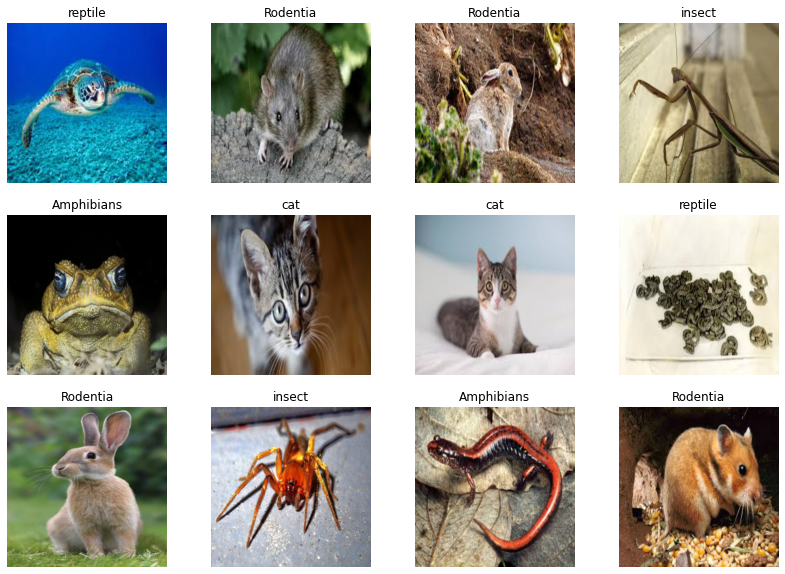

In [28]:
class_plot(train_data, encoder, inv_normalize=inv_normalize, random_seed=None)

In [29]:
def train_model(train_class, model, dataloaders, criterion, encoder, num_epochs=10, lr=0.001, batch_size=32, patience=None, classes=None, rgb=False, inv_normalize=None):
  train_class.model = model
  train_class.lr = lr
  
  dataloader_train = {}
  losses = list()
  accuracy = list()
  key = dataloaders.keys()

  for phase in key:
    if (phase == 'test'):
      perform_test = True
    else:
      dataloader_train.update([(phase, dataloaders[phase])])

  train_losses, train_acc, valid_losses, valid_acc = train_class.train(dataloader_train, criterion, num_epochs, batch_size, patience)

  train_class.error_plot(valid_losses)
  train_class.acc_plot(valid_acc)

  if (perform_test == True):
    true, pred, image, true_wrong, pred_wrong, epoch_acc, epoch_loss = train_class.test(dataloaders['test'], criterion, batch_size) 

    train_class.wrong_plot(12, true_wrong, image, pred_wrong, encoder, inv_normalize=inv_normalize)
    train_class.performance_matrix(true, pred)

    if classes != None:
      train_class.plot_confusion_matrix(true, pred, classes=classes, title='Confusion matrix, without normalization')

  return train_class.model 

In [30]:
classifier = pretrained_resnet152(freeze=True, n_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()

In [31]:
# from normalization import Normalize


class train_emotion6:
    def __init__(self, random_seed=None):
        """
        Args:
            mean (float): ===========================================================
            std (float): ============================================================
            attention_list (list): Receive a list of colors you want to give attention
            random_seed (int): Seed to fix the result
        """

        if random_seed is not None:
            torch.manual_seed(random_seed)
            torch.cuda.manual_seed(random_seed)
            #torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
            #torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
            np.random.seed(random_seed)
            random.seed(random_seed)

        self.model = None
        self.lr = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.earlystop = None

    # train
    def train(self, dataloaders, criterion, num_epochs, batch_size, patience):
        self.model.to(self.device)
        best_acc = 0.0
        phases = dataloaders.keys()

        train_losses = list()
        train_acc = list()
        valid_losses = list()
        valid_acc = list()

        # EarlyStopping
        if (patience != None):
            self.earlystop = EarlyStopping(patience=patience, verbose=True)

        for epoch in range(1, num_epochs + 1):
            print('Epoch {}/{}'.format(epoch, num_epochs))
            print('----------')
            optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

            # if (epoch % 10 == 0):
            #     self.lr *= 0.9

            for phase in phases:
                # Train
                if phase == 'train':

                    self.model.train()
                    running_loss = 0.0
                    running_corrects = 0
                    total = 0
                    j = 0

                    for batch_idx, (data, target) in enumerate(dataloaders[phase]):
                        data, target = Variable(data), Variable(target)
                        data = data.type(torch.cuda.FloatTensor)
                        target = target.type(torch.cuda.LongTensor)
                        optimizer.zero_grad()
                        output = self.model(data)
                        loss = criterion(output, target)
                        _, preds = torch.max(output, 1)
                        running_corrects = running_corrects + torch.sum(preds == target.data)
                        running_loss += loss.item() * data.size(0)
                        j = j + 1

                        loss.backward()
                        optimizer.step()
                                                                                                 
                    epoch_acc = running_corrects.double() / (len(dataloaders[phase])*batch_size)
                    epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)

                    train_losses.append(epoch_loss)
                    train_acc.append(epoch_acc)
                
                # Valid
                else:
                    with torch.no_grad():
                        self.model.eval()
                        running_loss = 0.0
                        running_corrects = 0
                        total = 0
                        j = 0

                        for batch_idx, (data, target) in enumerate(dataloaders[phase]):
                            data, target = Variable(data), Variable(target)
                            data = data.type(torch.cuda.FloatTensor)
                            target = target.type(torch.cuda.LongTensor)
                            optimizer.zero_grad()
                            output = self.model(data)

                            loss = criterion(output, target)
                            _, preds = torch.max(output, 1)
                            running_corrects = running_corrects + torch.sum(preds == target.data)
                            running_loss += loss.item() * data.size(0)
                            j = j + 1

                        epoch_acc = running_corrects.double() / (len(dataloaders[phase])*batch_size)
                        epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)

                        valid_losses.append(epoch_loss)
                        valid_acc.append(epoch_acc)

                print('{} Epoch: {}\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase, epoch, running_loss / (j * batch_size), running_corrects.double() / (j * batch_size)))
                
                if phase == 'valid' and (patience != None):
                    self.earlystop(epoch_loss, self.model)  # early stop with valid loss 

            # print('EalryStop :', self.earlystop.early_stop)

            if (patience != None) and (self.earlystop.early_stop):
                print("Early stopping")
                self.model.load_state_dict(torch.load('./gdrive/MyDrive/Colab Notebooks/dataset/checkpoint.pt'))
                break

            # print('{} Accuracy: '.format(phase),epoch_acc.item())
            print()

        return train_losses, train_acc, valid_losses, valid_acc

    # test
    def test(self, dataloader, criterion, batch_size):
        with torch.no_grad():
            self.model.eval()
            running_corrects = 0
            running_loss = 0
            pred = []
            true = []
            pred_wrong = []
            true_wrong = []
            image = []
            # sm = nn.LogSoftmax(dim=1)

            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.cuda.FloatTensor)
                target = target.type(torch.cuda.LongTensor)
                output = self.model(data)

                # need attention here
                
                loss = criterion(output, target)
                # output = sm(output)
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item() * data.size(0)
                preds = preds.cpu().numpy()
                target = target.cpu().numpy()
                preds = np.reshape(preds, (len(preds), 1))
                target = np.reshape(target, (len(preds), 1))
                data = data.cpu().numpy()

                for i in range(len(preds)):
                    pred.append(preds[i])
                    true.append(target[i])
                    if(preds[i] != target[i]):
                        pred_wrong.append(preds[i])
                        true_wrong.append(target[i])
                        image.append(data[i])

            epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
            epoch_loss = running_loss/(len(dataloader)*batch_size)

            print(epoch_acc, epoch_loss)

            return true, pred, image, true_wrong, pred_wrong, epoch_acc, epoch_loss

    def error_plot(self, loss):
        plt.figure(figsize=(10, 5))
        plt.plot(loss)
        plt.title("Valid loss plot")
        plt.xlabel("epochs")
        plt.ylabel("Loss")
        plt.show()


    def acc_plot(self, acc):
        plt.figure(figsize=(10, 5))
        plt.plot(acc)
        plt.title("Valid accuracy plot")
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.show()

    # To plot the wrong predictions given by model
    def wrong_plot(self, n_figures, true, ima, pred, encoder, inv_normalize):
        print('Classes in order Actual and Predicted')
        n_row = int(n_figures/3)
        fig, axes = plt.subplots(figsize=(14, 10), nrows=n_row, ncols=3)
        for ax in axes.flatten():
            a = random.randint(0, len(true)-1)

            image, correct, wrong = ima[a], true[a], pred[a]
            image = torch.from_numpy(image)
            correct = int(correct)
            c = encoder[correct]
            wrong = int(wrong)
            w = encoder[wrong]
            f = 'A:'+c + ',' + 'P:'+w
            if inv_normalize != None:
                image = inv_normalize(image)
            image = image.numpy().transpose(1, 2, 0)
            im = ax.imshow(image)
            ax.set_title(f)
            ax.axis('off')
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, classes,
                            normalize=False,
                            title=None,
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = metrics.confusion_matrix(y_true, y_pred)
        # Only use the labels that appear in the data
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return ax

    def performance_matrix(self, true, pred):
        precision = metrics.precision_score(true, pred, average='macro')
        recall = metrics.recall_score(true, pred, average='macro')
        accuracy = metrics.accuracy_score(true, pred)
        f1_score = metrics.f1_score(true, pred, average='macro')
        print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(
            precision* 100, recall* 100, accuracy* 100, f1_score* 100))
            

# EarlyStopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(
                f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), './gdrive/MyDrive/Colab Notebooks/dataset/checkpoint.pt')
        self.val_loss_min = val_loss


In [32]:
train_animal = train_emotion6(random_seed=random_seed)

Epoch 1/200
----------
train Epoch: 1	Loss: 0.669994 	Acc: 0.640625
valid Epoch: 1	Loss: 0.243157 	Acc: 0.601562
Validation loss decreased (inf --> 0.243157).  Saving model ...

Epoch 2/200
----------
train Epoch: 2	Loss: 0.176506 	Acc: 0.829427
valid Epoch: 2	Loss: 0.253424 	Acc: 0.593750
EarlyStopping counter: 1 out of 20

Epoch 3/200
----------
train Epoch: 3	Loss: 0.071478 	Acc: 0.859375
valid Epoch: 3	Loss: 0.306051 	Acc: 0.585938
EarlyStopping counter: 2 out of 20

Epoch 4/200
----------
train Epoch: 4	Loss: 0.057115 	Acc: 0.867188
valid Epoch: 4	Loss: 0.436792 	Acc: 0.585938
EarlyStopping counter: 3 out of 20

Epoch 5/200
----------
train Epoch: 5	Loss: 0.042109 	Acc: 0.872396
valid Epoch: 5	Loss: 0.543660 	Acc: 0.578125
EarlyStopping counter: 4 out of 20

Epoch 6/200
----------
train Epoch: 6	Loss: 0.017114 	Acc: 0.880208
valid Epoch: 6	Loss: 0.501095 	Acc: 0.578125
EarlyStopping counter: 5 out of 20

Epoch 7/200
----------
train Epoch: 7	Loss: 0.039967 	Acc: 0.877604
valid Epo

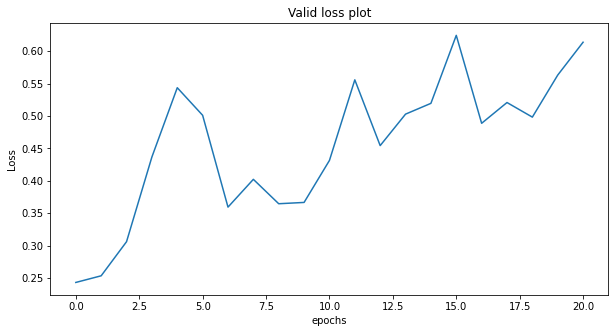

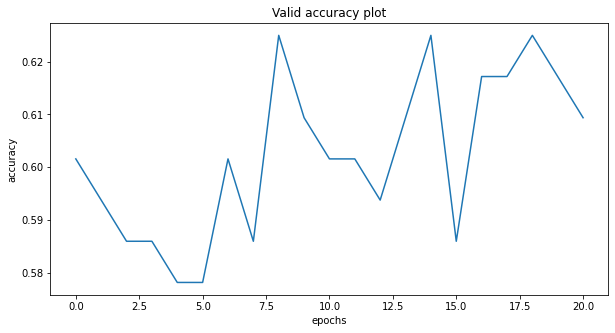

tensor(0.6406, device='cuda:0', dtype=torch.float64) 0.10724743036553264
Classes in order Actual and Predicted


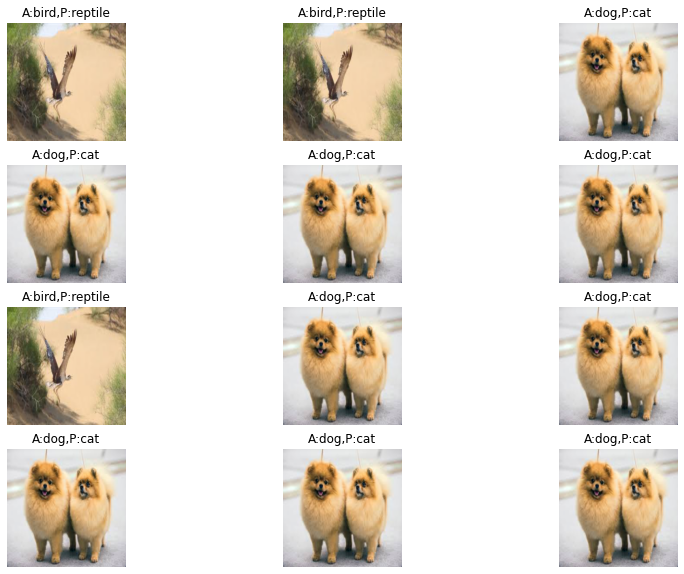

Precision: 97.43303571428572 Recall: 96.875, Accuracy: 97.61904761904762: ,f1_score: 96.96856906534326
Confusion matrix, without normalization
[[13  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  1]
 [ 0  0  0  6  0  0  0  0]
 [ 0  0  0  1  7  0  0  0]
 [ 0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0 15]]


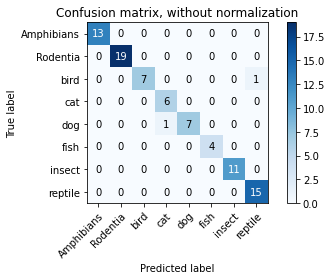

In [33]:
model = train_model(train_animal, classifier, dataloaders, criterion=criterion, encoder=encoder, num_epochs=epochs, lr=lr, batch_size=batch_size, patience=patience, classes=classes, inv_normalize=inv_normalize)

In [34]:
model = pretrained_resnet152(freeze=True, n_classes=len(classes))
model.load_state_dict(torch.load('./gdrive/MyDrive/Colab Notebooks/dataset/checkpoint.pt'))
model.eval()

pretrained_resnet152(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [35]:
model.parameters(0)

<generator object Module.parameters at 0x7f0adabecbf8>

tensor([[-5.7253e-03, -1.0986e+01, -1.5502e+01, -1.6328e+01, -1.4507e+01,
         -1.3962e+01, -1.1878e+01, -5.1702e+00]], grad_fn=<LogSoftmaxBackward>)
Amphibians


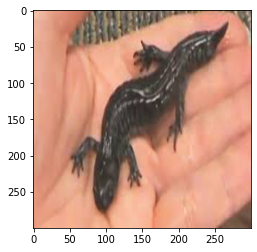

In [36]:
from PIL import Image

image = Image.open('gdrive/MyDrive/Colab Notebooks/dataset/animal_test_dataset/3.jfif')
# image = Image.open('./gdrive/MyDrive/Colab Notebooks/dataset/Animal_classification_dataset/cat/202.jpg')

test_transforms = transforms.Compose([transforms.Resize(size=(imsize, imsize)),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize(mean, std)])

image_tensor = test_transforms(image).float()

image_tensor = image_tensor.unsqueeze_(0)

input = Variable(image_tensor)

output = model(input)

print(output)

index = output.data.numpy().argmax()

print(encoder[index])

plt.imshow(image)
plt.show()

# image = (image - mean) / std
numpy_image1 = np.array(image)
image = torch.from_numpy(numpy_image1)
image = image.permute(2,0,1).unsqueeze(0)
image = Variable(image)
image = image.type(torch.FloatTensor)


# print(type(image))

# image = image.permute(2, 1,0)
# image  = image.unsqueeze(0)

#####################################################
# print(image.shape)

# output = model(image)
# print(output)

# _, preds = torch.max(output, 1)
# print(preds)

# print(encoder[int(preds)])

# lis = model(image)[0]
#####################################################
# image.transfroms = test_transforms

# train_data.dataset.transform = transform

# image.test_transforms

# test_image = DataLoader(image, batch_size=batch_size, shuffle=True)